In [ ]:
#!pip install nltk
#!pip install textblob
#!pip install wordcloud matplotlib


In [2]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize




In [3]:
# datasets
drug_reviews_drugs_com = fetch_ucirepo(id=462)
drug_reviews_druglib_com = fetch_ucirepo(id=461)

# Load the datasets
df1 = drug_reviews_drugs_com.data.features
df2 = drug_reviews_druglib_com.data.features


In [4]:
# Combine datasets
combined_df = pd.concat([df1, df2], ignore_index=True)


In [ ]:
## Exploratory Data Analysis (EDA)

In [ ]:
print(combined_df.head())
print(combined_df.info())
print("Unique Drug Names:", combined_df['urlDrugName'].nunique())
print("Unique Conditions:", combined_df['condition'].nunique())


In [ ]:
print(combined_df.describe())
print(combined_df['rating'].value_counts())


In [ ]:
# Convert reviews to string and calculate lengths
#converts review data into string format calculates the length of each review, stores those lengths in new columns
combined_df['benefitsLength'] = combined_df['benefitsReview'].astype(str).apply(len)
combined_df['sideEffectsLength'] = combined_df['sideEffectsReview'].astype(str).apply(len)
combined_df['commentsLength'] = combined_df['commentsReview'].astype(str).apply(len)

# Display descriptive statistics (lengths)
print(combined_df[['benefitsLength', 'sideEffectsLength', 'commentsLength']].describe())


In [ ]:
# Descriptive statistics for numerical columns
print(combined_df.describe())

# distribution of the rating column
print(combined_df['rating'].value_counts())


In [ ]:
plt.figure(figsize=(11, 8))
sns.countplot(data=combined_df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [ ]:
plt.figure(figsize=(9, 5))
sns.countplot(data=combined_df, x='effectiveness', palette='plasma')
plt.title('Effectiveness Distribution')
plt.xlabel('Effectiveness')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [ ]:
correlation_matrix = combined_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [ ]:

# Determine the top N useful review counts USING TOP #10
top_n = 10 
top_useful_counts = combined_df['usefulCount'].value_counts().nlargest(top_n)

plt.figure(figsize=(12, 6))

# the top N useful reviews
sns.countplot(data=combined_df[combined_df['usefulCount'].isin(top_useful_counts.index)],
                            x='usefulCount', palette='Set2', order=top_useful_counts.index)

# Customize the plot
plt.title('Distribution of Top Useful Reviews', fontsize=16)
plt.xlabel('Useful Reviews Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # grid for better readability
plt.tight_layout()  

# Show the plot
plt.show()



In [5]:
def rename_columns(df):
    df = df.rename(columns={
        'urlDrugName': 'drug_name',
        'effectiveness': 'effectiveness',
        'sideEffects': 'side_effects',
        'benefitsReview': 'benefits_review',
        'sideEffectsReview': 'side_effects_review',
        
    })
    return df

df1 = rename_columns(df1)
df2 = rename_columns(df2)

# Check the column names
print("Columns in Dataset 1:", df1.columns)
print("Columns in Dataset 2:", df2.columns)


Columns in Dataset 1: Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'], dtype='object')
Columns in Dataset 2: Index(['drug_name', 'rating', 'effectiveness', 'side_effects', 'condition',
       'benefits_review', 'side_effects_review', 'commentsReview'],
      dtype='object')


In [ ]:
def plot_drug_ratings(df, dataset_name, top_n=30):
    plt.figure(figsize=(12, 6))
    
    # Check if drug_name exists 
    if 'drug_name' in df.columns:
        # Get the top N drugs based on count
        top_drugs = df['drug_name'].value_counts().nlargest(top_n).index
        sns.countplot(data=df[df['drug_name'].isin(top_drugs)], x='drug_name', order=top_drugs)
        plt.title(f'Top {top_n} Drug Ratings Count in {dataset_name}')
        plt.xticks(rotation=90)
        plt.show()
    else:
        print(f"'drug_name' column not found in {dataset_name}.")

# Plot for both datasets
plot_drug_ratings(df1, "Dataset 1", top_n=30)
plot_drug_ratings(df2, "Dataset 2", top_n=30)


In [ ]:
def plot_word_cloud(df, column_name, dataset_name):
    plt.figure(figsize=(10, 8))
    
    # Check if the column exists
    if column_name in df.columns:
        # Combine all reviews into a single string
        all_reviews = ' '.join(df[column_name].dropna())
        
        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)
        
        # Display the word cloud
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # Hide axes
        plt.title(f'Word Cloud for {column_name} in {dataset_name}')
        plt.show()
    else:
        print(f"'{column_name}' column not found in {dataset_name}.")

#  word clouds for both datasets
plot_word_cloud(df1, 'benefits_review', "Dataset 1")
plot_word_cloud(df2, 'benefits_review', "Dataset 2")


In [ ]:
def plot_drug_word_cloud(df, dataset_name):
    plt.figure(figsize=(10, 8))
    
    # Check if 'drug_name' column exists
    if 'drug_name' in df.columns:
        # Combine all drug names into a single string
        all_drugs = ' '.join(df['drug_name'].dropna())
        
        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_drugs)
        
        # Display the word cloud
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # Hide axes
        plt.title(f'Word Cloud of Drug Names in {dataset_name}')
        plt.show()
    else:
        print(f"'drug_name' column not found in {dataset_name}.")

# Create word clouds for drug names in both datasets
plot_drug_word_cloud(df1, "Dataset 1")
plot_drug_word_cloud(df2, "Dataset 2")


In [ ]:
def plot_word_frequency(df, column_name):
    if column_name in df.columns:
        all_reviews = ' '.join(df[column_name].dropna())
        words = all_reviews.split()
        word_freq = pd.Series(words).value_counts().head(20)  # Top 20 words
        word_freq.plot(kind='bar', figsize=(12, 6))
        plt.title(f'Top 20 Words in {column_name}')
        plt.show()
    else:
        print(f"'{column_name}' column not found in the DataFrame.")

# Plot for benefits reviews
plot_word_frequency(df1, 'benefits_review')
plot_word_frequency(df2, 'benefits_review')


In [ ]:
# Generate word cloud for conditions in df1
condition_text = ' '.join(df1['condition'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(condition_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Conditions in Reviews (Dataset 1)')
plt.show()


In [ ]:
# Generate word cloud for side effects in df2
side_effects_text = ' '.join(df2['side_effects_review'].dropna())  # Use df2 for Dataset 2
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(side_effects_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Side Effects in Reviews (Dataset 2)')
plt.show()


In [ ]:
# Generate word cloud for conditions in df2
condition_text = ' '.join(df2['condition'].dropna())  # Use df2 and focus on 'condition' column
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(condition_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Conditions in Reviews (Dataset 2)')
plt.show()


In [6]:
# Function to clean text (remove punctuation, lowercase, remove numbers)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply the cleaning function to the review column
df1['cleaned_review'] = df1['review'].apply(clean_text)

# Check cleaned reviews
print("Cleaned review:", df1['cleaned_review'].head())


Cleaned review: 0    it has no side effect i take it in combination...
1    my son is halfway through his fourth week of i...
2    i used to take another oral contraceptive whic...
3    this is my first time using any form of birth ...
4    suboxone has completely turned my life around ...
Name: cleaned_review, dtype: object


In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')  
# Set of English stop words
stop_words = set(stopwords.words('english'))

# Function to clean text (remove punctuation, lowercase, remove numbers)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Function to tokenize and remove stopwords
def tokenize_and_remove_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text)
        words = [word for word in words if word not in stop_words]
        return words
    return []  # Return an empty list if text is not a string

# Clean the review column
df1['cleaned_review'] = df1['review'].apply(clean_text)

# Apply tokenization and stopword removal
df1['tokens_review'] = df1['cleaned_review'].apply(tokenize_and_remove_stopwords)

# tokenized data
print("Tokenized review:", df1['tokens_review'].head())


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/katerineosorio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katerineosorio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/katerineosorio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Tokenized review: 0    [side, effect, take, combination, bystolic, mg...
1    [son, halfway, fourth, week, intuniv, became, ...
2    [used, take, another, oral, contraceptive, pil...
3    [first, time, using, form, birth, control, im,...
4    [suboxone, completely, turned, life, around, f...
Name: tokens_review, dtype: object


In [8]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize words
def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization
df1['lemmatized_review'] = df1['tokens_review'].apply(lemmatize_words)

# lemmatized data
print("Lemmatized review:", df1['lemmatized_review'].head())


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/katerineosorio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Lemmatized review: 0    [side, effect, take, combination, bystolic, mg...
1    [son, halfway, fourth, week, intuniv, became, ...
2    [used, take, another, oral, contraceptive, pil...
3    [first, time, using, form, birth, control, im,...
4    [suboxone, completely, turned, life, around, f...
Name: lemmatized_review, dtype: object


In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Sample the DataFrame to limit processing time
sample_df = df1.sample(n=min(1000, len(df1)), random_state=42)  # Sample up to 1000 rows

# Function to get sentiment score
def analyze_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)
    else:
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

# Apply sentiment analysis
sample_df['comments_review_sentiment'] = sample_df['lemmatized_review'].apply(analyze_sentiment)

# Extract compound sentiment score
sample_df['comments_sentiment_score'] = sample_df['comments_review_sentiment'].apply(lambda x: x['compound'])

# sentiment scores
print("Sentiment scores for comments reviews:")
print(sample_df[['comments_sentiment_score']].head())


Sentiment scores for comments reviews:
        comments_sentiment_score
14311                          0
72301                          0
23041                          0
197721                         0
133612                         0


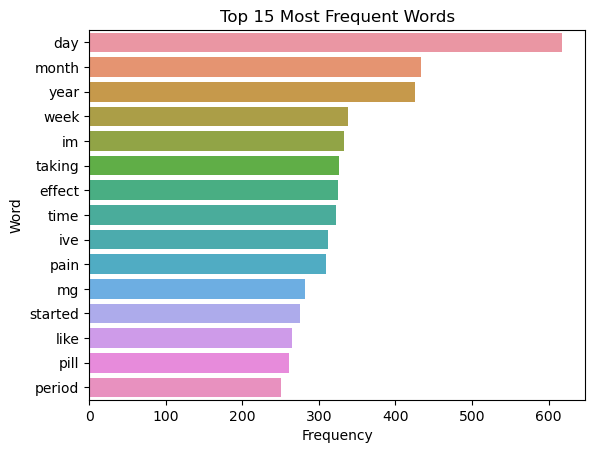

In [12]:
from sklearn.feature_extraction.text import CountVectorizer


def plot_most_frequent_words(text_column, top_n=10):
    # Use CountVectorizer to get word frequencies
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    word_matrix = vectorizer.fit_transform(text_column)
    word_freq = np.asarray(word_matrix.sum(axis=0)).flatten()
    words = vectorizer.get_feature_names_out()

    # Create a DataFrame for plotting
    word_freq_dict = dict(zip(words, word_freq))
    sorted_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)
    word_df = pd.DataFrame(sorted_words, columns=['Word', 'Frequency'])

    # Plot the results
    sns.barplot(x='Frequency', y='Word', data=word_df)
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.show()

# Check for the original review column
if 'lemmatized_review' in df1.columns:  
    # Sample 1000 rows for plotting
    sample_df = df1.sample(n=1000)

    # Plot the most frequent words in the original comments
    plot_most_frequent_words(sample_df['lemmatized_review'].astype(str), top_n=15)
else:
    print("The required column 'lemmatized_review' is missing.")


In [14]:
from sklearn.decomposition import LatentDirichletAllocation

# Check if necessary columns exist
if 'lemmatized_review' in df1.columns:  
    # Sample a smaller subset of the DataFrame 
    sample_df = df1.sample(n=min(1000, len(df1)), random_state=42)  # Sample up to 1000 rows

    # Use the text column for topic modeling
    text_column = sample_df['lemmatized_review'].astype(str) 

    # Use CountVectorizer for LDA with a limit on the number of features
    vectorizer = CountVectorizer(stop_words='english', max_features=500)  # Reduce max_features to 500
    X = vectorizer.fit_transform(text_column)

    # Apply LDA for topic modeling with fewer topics
    lda = LatentDirichletAllocation(n_components=3, random_state=42) 
    lda.fit(X)

    # Function to display top words in each topic
    def print_lda_topics(lda, vectorizer, top_n=10):
        words = vectorizer.get_feature_names_out()
        for i, topic in enumerate(lda.components_):
            print(f"Topic {i + 1}:")
            print([words[i] for i in topic.argsort()[-top_n:]])

    # Print the top words for each topic
    print_lda_topics(lda, vectorizer)
else:
    print("The required column 'lemmatized_review' is missing.")


Topic 1:
['acne', 'day', 'skin', 'weight', 'week', 'started', 'month', 'im', 'year', 'ive']
Topic 2:
['im', 'work', 'doctor', 'time', 'effect', 'year', 'taking', 'pain', 'mg', 'day']
Topic 3:
['effect', 'time', 'got', 'birth', 'control', 'day', 'week', 'pill', 'month', 'period']
